In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import pandas as pd

# Read the CSV file in the same directory as the code
data = pd.read_csv('../data/The_Cancer_data_1500_V2.csv')
# cancer_diag_data = pd.read_csv(data, sep = ',', header = 0)
print("Dataset: ")
data.head()

Dataset: 


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [3]:
# Separate features and target
X = data.drop(columns='Diagnosis')
y = data['Diagnosis']

# Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

In [5]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
}

In [6]:
#function to perform training with entropy
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)

In [7]:
# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator= decision_tree , param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

In [8]:
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_decision_tree = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'max_depth': None, 'min_samples_split': 10}


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract results from the grid search
cv_results = pd.DataFrame(grid_search.cv_results_)

# Sort results by best performance
cv_results = cv_results.sort_values(by='rank_test_score')

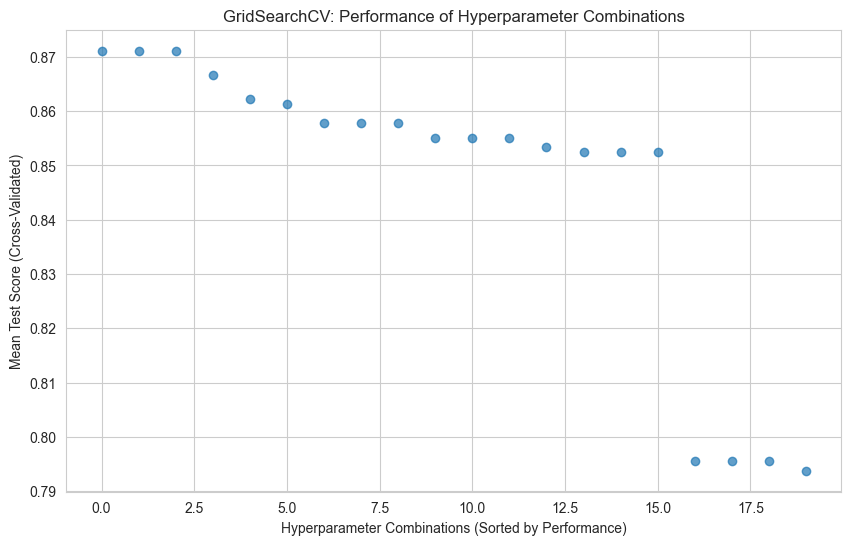

In [10]:
# Scatter plot for mean test score vs. hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.scatter(range(len(cv_results)), cv_results['mean_test_score'], alpha=0.7)
plt.xlabel('Hyperparameter Combinations (Sorted by Performance)')
plt.ylabel('Mean Test Score (Cross-Validated)')
plt.title('GridSearchCV: Performance of Hyperparameter Combinations')
plt.show()

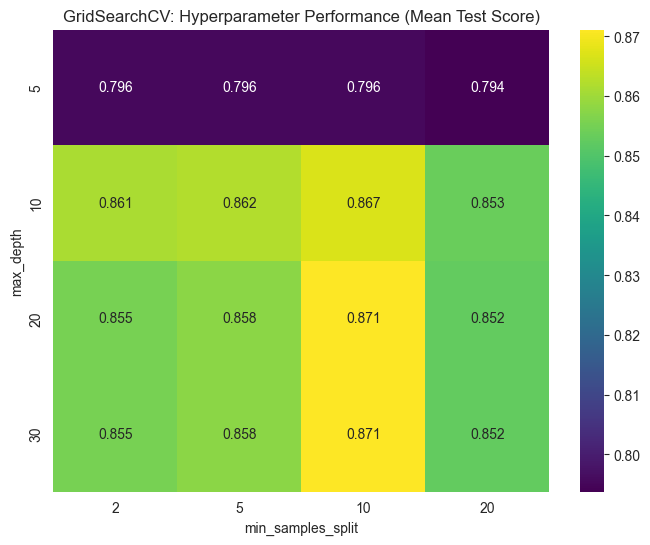

In [11]:
import seaborn as sns
import numpy as np

# Assuming 'param_max_depth' and 'param_min_samples_split' are columns in cv_results_
pivot_table = cv_results.pivot_table(values='mean_test_score', 
                                     index='param_max_depth', 
                                     columns='param_min_samples_split')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('GridSearchCV: Hyperparameter Performance (Mean Test Score)')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()

In [12]:
# Display the top 10 combinations and their scores
print(cv_results[['params', 'mean_test_score', 'rank_test_score']].head(10))

                                          params  mean_test_score  \
2   {'max_depth': None, 'min_samples_split': 10}         0.871111   
14    {'max_depth': 20, 'min_samples_split': 10}         0.871111   
18    {'max_depth': 30, 'min_samples_split': 10}         0.871111   
10    {'max_depth': 10, 'min_samples_split': 10}         0.866667   
9      {'max_depth': 10, 'min_samples_split': 5}         0.862222   
8      {'max_depth': 10, 'min_samples_split': 2}         0.861333   
13     {'max_depth': 20, 'min_samples_split': 5}         0.857778   
1    {'max_depth': None, 'min_samples_split': 5}         0.857778   
17     {'max_depth': 30, 'min_samples_split': 5}         0.857778   
16     {'max_depth': 30, 'min_samples_split': 2}         0.855111   

    rank_test_score  
2                 1  
14                1  
18                1  
10                4  
9                 5  
8                 6  
13                7  
1                 7  
17                7  
16               10 

In [13]:
# Train the models
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test)
y_pred_forest = random_forest.predict(X_test)

# Calculate accuracy and classification reports for both models
accuracy_tree = accuracy_score(y_test, y_pred_tree)
accuracy_forest = accuracy_score(y_test, y_pred_forest)

classification_report_tree = classification_report(y_test, y_pred_tree)
classification_report_forest = classification_report(y_test, y_pred_forest)

(accuracy_tree, accuracy_forest, classification_report_tree, classification_report_forest)

(0.872,
 0.9173333333333333,
 '              precision    recall  f1-score   support\n\n           0       0.88      0.91      0.90       233\n           1       0.85      0.80      0.83       142\n\n    accuracy                           0.87       375\n   macro avg       0.87      0.86      0.86       375\nweighted avg       0.87      0.87      0.87       375\n',
 '              precision    recall  f1-score   support\n\n           0       0.92      0.95      0.93       233\n           1       0.92      0.86      0.89       142\n\n    accuracy                           0.92       375\n   macro avg       0.92      0.91      0.91       375\nweighted avg       0.92      0.92      0.92       375\n')

In [14]:
#function to perform training with entropy
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)